In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
hol = pd.read_csv('./holidays_events.csv')
oil = pd.read_csv('./oil.csv')
sample_submission = pd.read_csv('./sample_submission.csv')
test = pd.read_csv('./test.csv')
train = pd.read_csv('./train.csv')

In [3]:
train.head(3)

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0


In [4]:
train['family'].value_counts().shape

(33,)

In [5]:
train['date'] = pd.to_datetime(train['date'])
monthly_sales = train.resample('M', on='date').sum()['sales']

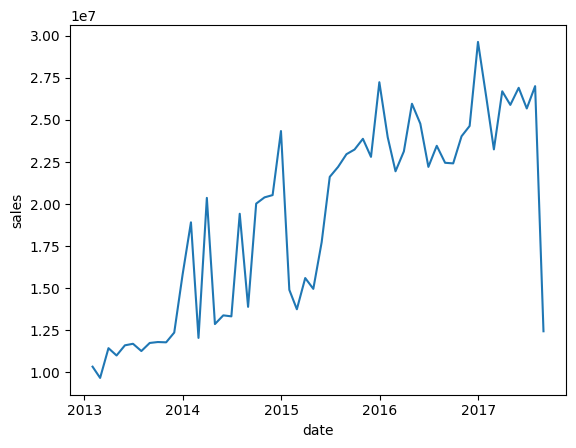

In [6]:
sns.lineplot(monthly_sales);

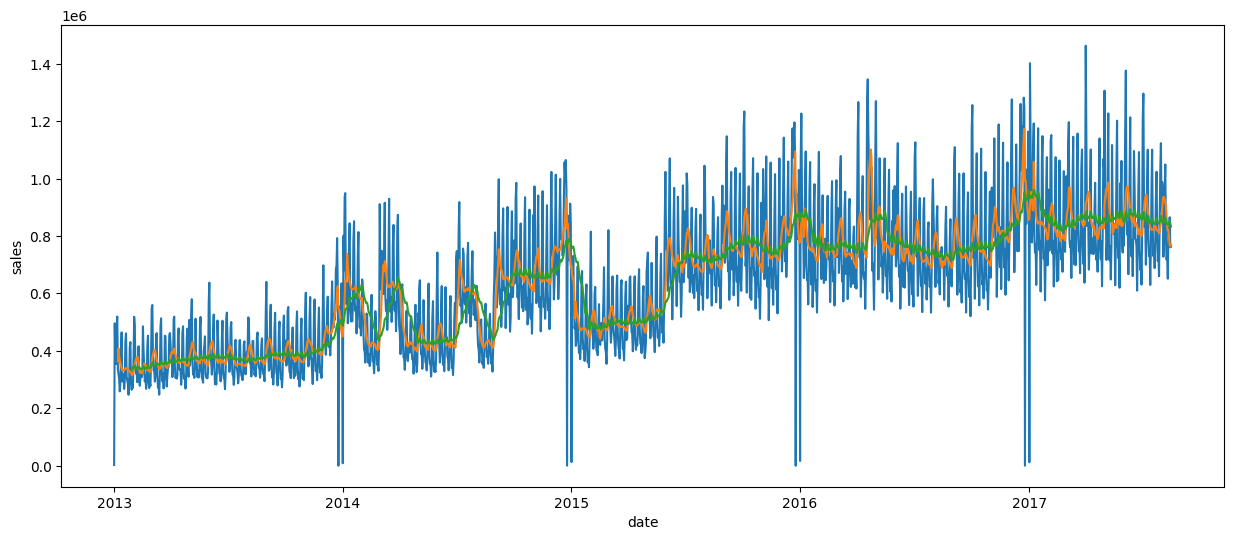

In [7]:
daily_sales = train.resample('D', on='date').sum()['sales']

daily_sales_rolling7d = daily_sales.rolling(window=7).mean()
daily_sales_rolling30d = daily_sales.rolling(window=30).mean()

plt.figure(figsize=(15,6))
sns.lineplot(daily_sales)
sns.lineplot(daily_sales_rolling7d)
sns.lineplot(daily_sales_rolling30d)
plt.show()

In [8]:
train['year'] = train['date'].dt.year
train['month'] = train['date'].dt.month
train['day'] = train['date'].dt.day
train['week_day'] = train['date'].dt.dayofweek

In [9]:
test['date'] = pd.to_datetime(test['date'])
test['year'] = test['date'].dt.year
test['month'] = test['date'].dt.month
test['day'] = test['date'].dt.day
test['week_day'] = test['date'].dt.dayofweek

In [20]:
hol['date'] = pd.to_datetime(hol['date'])
train = train.merge(hol, how='left', on='date')

*encoding hollidays* 

In [24]:
train['locale_name'].value_counts().shape, train['type'].value_counts().shape,

((24,), (6,))

In [44]:
def encode_holiday_type(df, enc, subset='train'):
    if subset == 'train':
        df['type'] = enc.fit_transform(df['type'].values.reshape(-1,1))
    else:
        df['type'] = enc.transform(df['type'].values.reshape(-1,1))
        not_hol_val = oe.transform([['not_holiday_type']])[0,0]
        df.loc[df['type']==-1, 'type'] = not_hol_val
    return df

def encode_holiday_locale(df, enc, subset='train'):
    if subset == 'train':
        df['locale'] = enc.fit_transform(df['locale'].values.reshape(-1,1))
    else: 
        df['locale'] = enc.transform(df['locale'].values.reshape(-1,1))
        not_hol_val = oe.transform([['not_hol']])[0,0]
        df.loc[df['locale']==-1, 'locale'] = not_hol_val
    return df

def feature_engineer(df):
    new_df = df.copy()
    new_df["month"] = df["date"].dt.month
    new_df["month_sin"] = np.sin(new_df['month'] * (2 * np.pi / 12))
    new_df["month_cos"] = np.cos(new_df['month'] * (2 * np.pi / 12))
    new_df["day"] = df["date"].dt.day
    new_df["day_sin"] = np.sin(new_df['day'] * (2 * np.pi / 12))
    new_df["day_of_week"] = df["date"].dt.dayofweek
    new_df["day_of_week"] = new_df["day_of_week"].apply(lambda x: 0 if x<=3 else(1 if x==4 else (2 if x==5 else (3))))
    
    new_df["day_of_year"] = df["date"].dt.dayofyear
    #account for leap year
    new_df["day_of_year"] = new_df.apply(lambda x: x["day_of_year"]-1 if (x["date"] > pd.Timestamp("2020-02-29") and x["date"] < pd.Timestamp("2021-01-01"))  else x["day_of_year"], axis=1)
    new_df["important_dates"] = new_df["day_of_year"].apply(lambda x: x if x in [1,2,3,4,5,6,7,8,125,126,360,361,362,363,364,365] else 0)
    
    new_df["year"] = df["date"].dt.year
    new_df = new_df.drop(columns=["date","month","day", "day_of_year"])
    return new_df


In [35]:
train_agg = train.groupby('date')['sales'].sum().reset_index()

test_agg = test.groupby(["date"])["id"].first().reset_index().drop(columns="id")
test_dates = test_agg[["date"]]

In [ ]:
oe = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

train_pred = pd.DataFrame()
train_pred['date'] = train_agg['date']

y_train = train_agg["sales"]
X_train = train_agg.drop(columns="sales")
X_test = test_agg

X_train = feature_engineer(X_train)
X_test = feature_engineer(X_test)

X_train = encode_holiday_names(X_train, oe)
X_test = encode_holiday_names(X_test, oe)